In [1]:
import pandas as pd
import numpy as np
import nltk

In [2]:
def loadGloveModel():
    dim = "50"
    f = open('../Models/glove.6B/glove.6B.' + dim + 'd.txt','r', encoding='utf-8')
    model = {}
    for i, line in enumerate(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    f.close()
    return model

In [ ]:
glove_model = loadGloveModel()

In [3]:
import glob

pos_file_names = glob.glob('./train/train/pos/*')
neg_file_names = glob.glob('./train/train/neg/*')

In [6]:
import nltk

In [7]:
tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False)

In [8]:
reviews = []
for fn in pos_file_names:
    with open(fn, encoding='utf-8') as f:
        content = f.read()
    content = tokenizer.tokenize(content)
    reviews.append((content,1))
    
for fn in neg_file_names:
    with open(fn, encoding='utf-8') as f:
        content = f.read()
    content = tokenizer.tokenize(content)
    reviews.append((content,0))

In [9]:
reviews_df = pd.DataFrame(reviews, columns=['review', 'pos'])

In [10]:
reviews_df.to_csv("./data/reviews_df.csv")

In [10]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [11]:
def glove_score(review, adj=False):
    ''' Gives a glove score against a review using Glove word embedding
    
        review - list of Str
        
        returns DataFrame
    '''

    list_score_df = []
    if adj == True:
        pos_tagged = nltk.pos_tag(review)
        first = True
        for i, curr_tuple in enumerate(pos_tagged):
            prev_tag = pos_tagged[i-1][1]
            prev_word = pos_tagged[i-1][0]
            curr_word = curr_tuple[0]
            curr_tag = curr_tuple[1]
            if curr_tag == 'JJ':
                if first:
                    if curr_word in glove_model \
                    and curr_word not in stopwords:
                        list_score_df.append(glove_model[curr_word])
                        first = False
                else:
                    if curr_word in glove_model \
                    and curr_word not in stopwords:
                        if prev_tag == 'RB' and prev_word in glove_model \
                        and prev_word not in stopwords:
                            row_df = glove_model[prev_word]
                            list_score_df.append(row_df)
                        row_df = glove_model[curr_word]
                        list_score_df.append(row_df)
        try:
            score_df = pd.DataFrame(list_score_df)
            score_df = np.sum(score_df)
            return pd.DataFrame(score_df).transpose()
        except ValueError:
            print("Value Error with this review: \n", review)
            return {} 
    else:
        for i, curr_word in enumerate(review):
            if i == 0:
                if curr_word in glove_model \
                and curr_word not in stopwords:
                    list_score_df.append(glove_model[curr_word])
            else:
                if curr_word in glove_model \
                and curr_word not in stopwords:
                    row_df = glove_model[curr_word]
                    list_score_df.append(row_df)
        try:
            score_df = pd.DataFrame(list_score_df)
            score_df = np.sum(score_df)
            return pd.DataFrame(score_df).transpose()
        except ValueError:
            print("Value Error with this review: \n", review)
            return {}

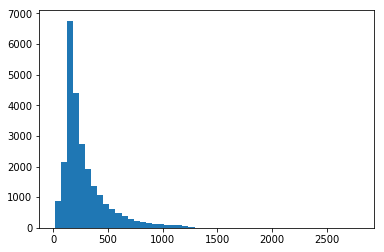

In [33]:
#Trying to decide where to cut off the maximum word length

from matplotlib import pyplot as plt
plt.hist(reviews_df.iloc[:,0].apply(lambda lst: len(lst)),bins=50)
plt.show()

In [36]:
np.percentile(reviews_df.iloc[:,0].apply(lambda lst: len(lst)), 95)

718.0

In [35]:
np.mean(reviews_df.iloc[:,0].apply(lambda lst: len(lst)))

280.64652

I think 800 would be a good number to encompass over 95% of the data

In [11]:
def glove_full(review, adj=False):
    ''' Takes a review and replaces words with word embeddings. No aggregations.
    
        review - list of Str
        
        returns DataFrame
    '''
    glove_dim = 50
    max_length = 800
    review_vector = np.zeros((max_length, glove_dim))
    ind = 0
    for i, curr_word in enumerate(review):       
        if ind == 800:
            break
        elif curr_word in glove_model \
        and curr_word not in stopwords:
            review_vector[ind, :] = glove_model[curr_word]
            ind += 1
        elif curr_word not in stopwords:
            review_vector[ind, :] = glove_model['<unk>']   # unknown token
            ind += 1
    return review_vector

In [12]:
# for aggregated glove
scores_df = pd.DataFrame()
for i, row in reviews_df.iterrows():
    s_df = glove_score(reviews_df.iloc[i,0])
    if i % 1000 == 0:
        print(i)
    scores_df = scores_df.append(s_df,ignore_index=True)

NameError: name 'glove_score' is not defined

In [13]:
# for non aggregated glove
list_of_review_scores = []
for i, row in reviews_df.iterrows():
    review_mat = glove_full(reviews_df.iloc[i,0])
    if i % 1000 == 0:
        print(i)
    list_of_review_scores.append(review_mat)
    
review_scores = np.asarray(list_of_review_scores)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


In [14]:
del list_of_review_scores

In [15]:
review_scores.shape

(25000, 800, 50)

In [17]:
np.save('./data/review_scores.npy', review_scores)

In [18]:
del glove_model

In [18]:
from sklearn.cross_validation import train_test_split

C:\Users\Jared\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(reviews_df.iloc[:,0], reviews_df.iloc[:,1],)

In [20]:
sum(y_train)


9396

In [21]:
sum(y_test)

3104

In [22]:
X_train = scores_df.iloc[y_train.index]
X_test = scores_df.iloc[y_test.index]

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75)

In [63]:
X_train.to_csv("./data/X_train")
X_val.to_csv("./data/X_val")
X_test.to_csv("./data/X_test")
y_train.to_csv("./data/y_train")
y_val.to_csv("./data/y_val")
y_test.to_csv("./data/y_test")

In [6]:
X_train = pd.read_csv("./data/X_train",index_col=0)
X_val = pd.read_csv("./data/X_val", index_col=0)
X_test = pd.read_csv("./data/X_test", index_col=0)
y_train = pd.read_csv("./data/y_train", index_col=0)
y_val = pd.read_csv("./data/y_val", index_col=0)
y_test = pd.read_csv("./data/y_test", index_col=0)

In [7]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
23466,-9.530130,5.256128,6.528821,-5.576692,1.611942,0.557120,-17.161828,12.029130,-0.591008,-158.001536,...,-1.915202,-14.362643,-10.617706,3.466634,-4.418027,18.719916,-2.894185,-2.608892,-7.436052,8.361118
4830,-9.071622,2.856857,-5.939990,-5.659706,0.378291,13.940015,-5.771536,3.221016,3.105647,-124.297551,...,6.918535,-12.327835,2.293610,1.302110,5.220683,-19.774624,2.891981,-15.062416,-2.457781,15.464681
24948,-6.190051,-3.199577,5.211514,-5.897536,-0.182303,9.425621,-12.014888,18.564904,-1.132379,-108.502450,...,-5.656457,-2.219772,-5.192971,-1.484033,11.546587,-13.245098,9.493588,-17.866740,-3.454605,17.845281
23736,-1.062833,-2.315163,-3.424130,-2.142048,-0.125433,8.022907,-11.455393,16.721467,5.193775,-109.108859,...,-4.850501,-5.386972,-3.186071,-0.280276,0.734114,-8.987849,7.224415,-9.832436,-1.555770,12.914127
2379,-12.053769,-9.009227,6.841530,-12.042793,2.928985,11.874726,-24.734865,21.170251,-3.272141,-161.999388,...,-9.767677,-7.178676,8.009605,-7.917645,2.532413,-3.049287,8.429122,-22.099984,1.411121,31.630693
23526,-0.707302,7.095887,10.054959,-9.228204,-0.063536,23.897032,-58.378764,53.419397,1.213361,-376.578505,...,-15.783971,2.203979,-22.033561,-14.086114,11.929373,-13.709570,26.395440,-25.057489,-13.350622,33.441044
15168,-3.222536,3.121683,4.156988,-6.959905,7.142618,11.815751,-13.505236,17.294490,-0.605547,-94.353434,...,-3.507356,-4.052887,-6.261077,-1.646614,-1.030465,-3.727235,3.517439,-12.853355,2.797053,7.115327
5539,-36.023182,35.783280,23.638059,-33.476221,23.090962,41.879738,-45.798463,55.679137,5.525473,-632.572143,...,-40.299987,-29.439347,-50.505792,13.707982,18.225685,6.371740,-11.089697,-36.399549,-11.360035,26.103479
7575,-1.955456,-2.541169,3.302431,-12.418295,-18.010573,13.837541,-16.857491,20.017110,1.982764,-128.073439,...,-10.488233,0.155041,-8.392291,-9.963056,12.395026,-5.209892,0.391239,-14.379635,-1.777981,28.843793
14242,-8.261153,-4.963909,-0.235948,-3.660342,-3.359656,6.031268,0.092088,-0.482050,9.402231,-99.443276,...,0.755983,-4.640630,-1.060889,7.147705,0.146469,-7.309369,3.796514,-8.246084,1.834856,19.446099


In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LeakyReLU, Dropout
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from sklearn.preprocessing import normalize

C:\Users\Jared\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
sgd = optimizers.SGD(lr=0.01, nesterov=True)
rms = optimizers.RMSprop()
adam = optimizers.Adam()

In [10]:
model = Sequential()
model.add(Dense(300, input_dim=300))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Dense(1000))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Dense(500))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Dense(250))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Dense(100))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Dense(50))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

Notes:

After trying different models between sgd, rms and adam, adam and rms are the fastest to get to 80% so far.

They max out around val_acc = 83%

In [31]:
model.compile(optimizer=rms, loss='binary_crossentropy', metrics=['accuracy'])
hist2 = model.fit(X_train, y_train, epochs=10000, batch_size=32, validation_data=(X_val, y_val))

Train on 14062 samples, validate on 4688 samples
Epoch 1/10000
14062/14062 [==============================] - 13s 936us/step - loss: 0.5913 - acc: 0.7096 - val_loss: 0.4994 - val_acc: 0.7993
Epoch 2/10000
14062/14062 [==============================] - 8s 548us/step - loss: 0.4544 - acc: 0.7971 - val_loss: 0.5060 - val_acc: 0.8006
Epoch 3/10000
14062/14062 [==============================] - 8s 573us/step - loss: 0.4356 - acc: 0.8102 - val_loss: 0.4191 - val_acc: 0.8172
Epoch 4/10000
14062/14062 [==============================] - 8s 562us/step - loss: 0.4189 - acc: 0.8165 - val_loss: 0.4401 - val_acc: 0.8142
Epoch 5/10000
14062/14062 [==============================] - 9s 627us/step - loss: 0.4165 - acc: 0.8181 - val_loss: 0.3855 - val_acc: 0.8351
Epoch 6/10000
14062/14062 [==============================] - 9s 645us/step - loss: 0.4093 - acc: 0.8195 - val_loss: 0.3946 - val_acc: 0.8319
Epoch 7/10000
14062/14062 [==============================] - 8s 600us/step - loss: 0.4041 - acc: 0.8187 

KeyboardInterrupt: 

### Error Analysis

In [34]:
predicted = np.reshape(model.predict(X_val), (-1))

In [36]:
actual = np.reshape(y_val, (-1))

C:\Users\Jared\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


In [40]:
diff = actual - np.round(predicted)

In [73]:
false_neg = reviews_df.iloc[X_val[diff==1].index]
false_pos = reviews_df.iloc[X_val[diff==-1].index]

In [58]:
#looking at random entries in false negative
rand_int = np.random.randint(0, len(false_neg))

In [60]:
print(rand_int, '\n\n')
[print(i) for i in false_neg.iloc[rand_int,0]]

a
very
strong
movie
.
bruce
is
good
and
brad
also
.
<
br
/
>
<
br
/
>
as
i
think
there
are
two
cities
missed
in
the
receptionist
list
from
the
list
bruce
remembered
.
<
br
/
>
<
br
/
>
that
means
the
woman
was
a
real
insurance
and
she
did
her
job
.
<
br
/
>
<
br
/
>
well
,
novikov
property
seems
to
me
work
in
this
movie
.
however
,
i
do
believe
in
back
to
the
future
theory
of
worlds
'
multiplicity
.
<
br
/
>
<
br
/
>
so
bruce
could
save
the
world
,
but
not
his
world
.
<
br
/
>
<
br
/
>
in
the
theory
of
parallel
worlds
the
man
can
meet
himself
.
<
br
/
>
<
br
/
>
and
i
do
believe
there
is
no
problem
in
that
.
here
i
disagree
with
dr
.
brown
from
back
...
<
br
/
>
<
br
/
>
but
the
story
pf
12
monkeys
has
its
own
beauty
.
inspite
of
all
these
theories
of
one
world
or
many
or
continuum
one
can
believe
that
he
is
really
insane
and
the
doctor
-
his
girlfriend
was
just
lost
.
<
br
/
>
<
br
/
>
a
sequence
of
events
which
may
lead
her
to
believe
that
he
is
from
the
future
.
the
bullet
-
well
it

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

It seems that a lot of false negatives are made because of summaries in movies. The summary contains negative words that the network picks up and interprets the review as negative.

In [86]:
#looking at random entries in false positive
rand_int = np.random.randint(0, len(false_pos))
# Obtained values 223, 320, 55

In [87]:
print(rand_int, '\n\n')
[print(i) for i in false_pos.iloc[rand_int,0]]

55 


stefan
is
an
x-con
that
five
years
ago
got
married
to
marie
.
their
marriage
has
been
stable
until
stefan
past
catch
up
with
them
and
he's
offered
to
do
a
courier
job
.
stefan's
job
is
a
heroin
delivery
from
germany
to
sweden
which
should
go
easily
.
<
br
/
>
<
br
/
>
in
germany
stefan
meet
elli
,
a
girl
from
bosnia
that
has
been
sold
to
a
stripclub
owner
.
stefan
dislikes
what
he
sees
and
decide
to
help
elli
out
of
her
misery
.
due
to
the
fact
that
elli's
father
during
the
war
fleed
to
sweden
elli
now
goes
with
stefan
to
sweden
.
to
make
up
with
the
past
stefan
promises
elli
to
help
her
find
her
father
,
no
matter
what
it
takes
.
finally
back
in
sweden
the
whole
situation
seems
to
be
more
complicated
than
stefan
ever
thought
of
..
<
br
/
>
<
br
/
>
this
movie
doesn't
seem
to
fit
in
the
ordinary
class
of
swedish
movies
due
to
the
fact
that
it's
been
americanized
alot
.
regina
lund
and
cecilia
bergqvist
makes
it
all
average
,
the
effects
makes
the
movie
a
little
too
much
though
.


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

223 is interesting because it is a great example of how position drastically affects sentiment. 

Here's a quote: "Its a good family movie; however if michael landon jr.'s editing team did a better job of editing, the movie would be much better." Sounds negative clearly.
Now rotating on the "however", we'd have:
"If michael landon jr.'s editing team did a better job of editing, the movie would be much better; however its a good family movie". Here, it sounds more positive! A model change might be in order. LTSM or CNN would be great at detecting these.


320 is filled with jokes that go over the neural network's head. Also filled with "positive words" but not saying somehting positive. Example: "it's
as if this movie was dreamt up at a shortland street cast christmas party , the result of too many gins , and possibly a bit of salmonella". This sentence is clearly negative to the human eye. But with data that simply aggregates through words, this sentence is filled with positive words and decoded in jokes.


55 is another example of the summary taking up a huge portion of the review, and then the actual opinionated piece is left at the end. Perhaps a solution to this is to find patterns in summaries so as to be able to separate summary from opinion like opinion statements usually have sentences like "this movie ____".

In [55]:
false_neg

,review,pos
11438,"[there, is, a, bit, of, trivia, which, should,...",1
11278,"["", the, blob, "", qualifies, as, a, cult, sci-...",1
978,"["", cut, "", is, a, full-tilt, spoof, of, the, ...",1
5336,"[guys, and, dolls, is, a, movie, itching, for,...",1
2741,"[ok, ,, this, movie, starts, out, like, a, che...",1
4778,"[this, is, simply, the, funniest, movie, i've,...",1
8854,"[i, remember, seeing, this, when, it, was, rel...",1
4914,"[an, imagination, is, a, terrible, thing, to, ...",1
2475,"[i, must, admit, i'm, a, little, surprised, an...",1
52,"[to, all, the, miserable, people, who, have, d...",1


In [119]:
np.reshape(model.predict(X_val), (-1))

array([0.726448  , 0.4589625 , 0.07255747, ..., 0.46413127, 0.20929205,
       0.01794988], dtype=float32)

In [111]:
from sklearn import metrics

In [121]:
metrics.accuracy_score(y_val, model.predict(X_val).round())

0.8378839590443686

In [114]:
X_val

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
1955,-2.709607,0.823322,-0.976731,-3.942001,2.466419,4.572990,-5.011948,-0.157489,0.726081,-54.957779,...,-0.171843,-8.035381,1.083654,5.119356,1.752086,6.575515,2.586730,-8.790066,-1.765028,2.371102
7410,-23.788113,18.849995,-5.478467,-28.850559,-2.977987,0.345442,-12.294386,16.698851,10.019337,-342.338497,...,-2.129589,-38.117047,-6.299583,23.221125,23.576995,22.822184,5.582503,-37.512159,-21.140500,13.774973
23895,-35.850669,15.220555,1.413695,-44.379361,-7.873908,31.699543,-34.713713,37.065645,9.976540,-458.033963,...,-20.993391,-43.211417,-20.704074,5.212338,36.088696,21.677928,11.571817,-69.118344,-21.848598,42.669947
10769,-10.986825,10.719739,3.078759,-13.467352,-1.792570,5.015190,-12.948430,4.535959,2.971679,-132.727480,...,-5.892459,-17.914209,-9.408483,6.720133,9.273998,5.329989,4.608194,-9.265466,-12.741729,11.088184
11934,-13.702834,19.802053,-4.625199,-19.982145,-6.132876,4.284878,-10.975221,5.712880,11.948668,-238.715968,...,-1.195186,-27.646590,0.126074,14.156489,7.526001,19.592931,4.628328,-28.717259,-19.414686,0.740996
20759,-22.053144,17.074883,-8.434952,-23.331036,-2.651745,11.588363,-14.444987,11.108250,15.252464,-275.128910,...,-5.502355,-34.103729,3.371719,10.743932,7.673473,-0.151231,-3.961266,-26.844456,-8.766967,3.362617
21388,-42.377950,32.686152,-2.381558,-64.923632,-20.516477,30.028512,-54.464985,39.650377,30.458246,-720.329316,...,-5.827593,-77.953762,-18.054393,29.590047,46.779906,5.194965,16.711095,-75.315097,-41.500587,44.811492
13678,-7.541792,6.129093,-0.594800,-6.274873,1.609949,-0.213843,-6.886704,6.109926,7.357906,-106.628828,...,-0.370001,-13.300510,1.454698,3.520301,8.904697,8.872277,-0.344592,-13.677129,-7.637608,4.256431
24133,-14.680323,5.433444,-7.738582,-14.968245,-1.674337,6.351103,-15.944126,6.924268,0.089956,-159.389650,...,-6.140383,-15.928990,-3.467835,2.890319,12.100413,0.381100,8.298843,-25.018817,-7.148896,18.951194
4114,-5.544905,6.907739,15.471430,-13.956575,2.924074,3.308911,-14.841988,29.147561,9.979552,-239.164830,...,-1.826192,-31.208858,1.823677,5.789113,5.687960,35.277971,-2.175263,-33.342825,-22.623583,9.120666


## Tweaking

Now we're trying with glove_score where we use adjectives and their previous adverbs!

In [47]:
scores_df = pd.DataFrame()
for i, row in reviews_df.iterrows():
    s_df = glove_score(reviews_df.iloc[i,0], adj=True)
    if i % 1000 == 0:
        print(i)
    scores_df = scores_df.append(s_df,ignore_index=True)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


In [48]:
X_train, X_test, y_train, y_test = train_test_split(reviews_df.iloc[:,0], reviews_df.iloc[:,1])

In [49]:
sum(y_train)


9365

In [50]:
sum(y_test)

3135

In [51]:
X_train = scores_df.iloc[y_train.index]
X_test = scores_df.iloc[y_test.index]

In [52]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75)

In [63]:
X_train[X_train.isnull().any(axis=1)]

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
4996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
X_train = X_train.dropna()
X_val = X_val.dropna()

In [65]:
y_train = y_train[X_train.index]
y_val = y_val[X_val.index]

In [66]:
sum(y_train)

7021

In [67]:
sum(y_test)

3135

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LeakyReLU, Dropout
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from sklearn.preprocessing import normalize

C:\Users\Jared\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [68]:
sgd = SGD(lr=0.05, nesterov=True)

In [69]:
model = Sequential()
model.add(Dense(300, input_dim=300))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Dense(1000))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Dense(500))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Dense(250))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Dense(100))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Dense(50))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

In [70]:
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['binary_crossentropy', 'accuracy'])
hist2 = model.fit(X_train, y_train, epochs=10000, batch_size=32, validation_data=(X_val, y_val))

Train on 14052 samples, validate on 4687 samples
Epoch 1/10000
14052/14052 [==============================] - 11s 806us/step - loss: 0.6109 - binary_crossentropy: 0.6109 - acc: 0.6731 - val_loss: 0.4963 - val_binary_crossentropy: 0.4963 - val_acc: 0.7732
Epoch 2/10000
14052/14052 [==============================] - 7s 465us/step - loss: 0.5196 - binary_crossentropy: 0.5196 - acc: 0.7528 - val_loss: 0.4755 - val_binary_crossentropy: 0.4755 - val_acc: 0.7796
Epoch 3/10000
14052/14052 [==============================] - 6s 459us/step - loss: 0.4975 - binary_crossentropy: 0.4975 - acc: 0.7679 - val_loss: 0.4536 - val_binary_crossentropy: 0.4536 - val_acc: 0.7881
Epoch 4/10000
14052/14052 [==============================] - 6s 461us/step - loss: 0.4896 - binary_crossentropy: 0.4896 - acc: 0.7690 - val_loss: 0.4774 - val_binary_crossentropy: 0.4774 - val_acc: 0.7800
Epoch 5/10000
14052/14052 [==============================] - 6s 462us/step - loss: 0.4793 - binary_crossentropy: 0.4793 - acc: 0.7

Epoch 80/10000
14052/14052 [==============================] - 6s 459us/step - loss: 0.4147 - binary_crossentropy: 0.4147 - acc: 0.8115 - val_loss: 0.4420 - val_binary_crossentropy: 0.4420 - val_acc: 0.7948
Epoch 81/10000
14052/14052 [==============================] - 7s 463us/step - loss: 0.4144 - binary_crossentropy: 0.4144 - acc: 0.8111 - val_loss: 0.4329 - val_binary_crossentropy: 0.4329 - val_acc: 0.7988
Epoch 82/10000
14052/14052 [==============================] - 6s 461us/step - loss: 0.4104 - binary_crossentropy: 0.4104 - acc: 0.8177 - val_loss: 0.4321 - val_binary_crossentropy: 0.4321 - val_acc: 0.7994
Epoch 83/10000
14052/14052 [==============================] - 7s 466us/step - loss: 0.4141 - binary_crossentropy: 0.4141 - acc: 0.8138 - val_loss: 0.4495 - val_binary_crossentropy: 0.4495 - val_acc: 0.7858
Epoch 84/10000
14052/14052 [==============================] - 6s 459us/step - loss: 0.4163 - binary_crossentropy: 0.4163 - acc: 0.8101 - val_loss: 0.4406 - val_binary_crossentr

Epoch 120/10000
14052/14052 [==============================] - 7s 491us/step - loss: 0.3938 - binary_crossentropy: 0.3938 - acc: 0.8256 - val_loss: 0.4622 - val_binary_crossentropy: 0.4622 - val_acc: 0.7871
Epoch 121/10000
14052/14052 [==============================] - 6s 461us/step - loss: 0.3913 - binary_crossentropy: 0.3913 - acc: 0.8267 - val_loss: 0.4392 - val_binary_crossentropy: 0.4392 - val_acc: 0.7999
Epoch 122/10000
14052/14052 [==============================] - 6s 462us/step - loss: 0.3916 - binary_crossentropy: 0.3916 - acc: 0.8254 - val_loss: 0.4419 - val_binary_crossentropy: 0.4419 - val_acc: 0.7975
Epoch 123/10000
14052/14052 [==============================] - 6s 461us/step - loss: 0.3996 - binary_crossentropy: 0.3996 - acc: 0.8228 - val_loss: 1.1986 - val_binary_crossentropy: 1.1986 - val_acc: 0.5443
Epoch 124/10000
14052/14052 [==============================] - 6s 463us/step - loss: 0.4043 - binary_crossentropy: 0.4043 - acc: 0.8173 - val_loss: 0.4327 - val_binary_cros

Epoch 199/10000
14052/14052 [==============================] - 6s 461us/step - loss: 0.3522 - binary_crossentropy: 0.3522 - acc: 0.8476 - val_loss: 0.4410 - val_binary_crossentropy: 0.4410 - val_acc: 0.7977
Epoch 200/10000
14052/14052 [==============================] - 6s 458us/step - loss: 0.3495 - binary_crossentropy: 0.3495 - acc: 0.8442 - val_loss: 0.4530 - val_binary_crossentropy: 0.4530 - val_acc: 0.7967
Epoch 201/10000
14052/14052 [==============================] - 6s 457us/step - loss: 0.3541 - binary_crossentropy: 0.3541 - acc: 0.8472 - val_loss: 0.4708 - val_binary_crossentropy: 0.4708 - val_acc: 0.7926
Epoch 202/10000
14052/14052 [==============================] - 7s 468us/step - loss: 0.3545 - binary_crossentropy: 0.3545 - acc: 0.8451 - val_loss: 0.5150 - val_binary_crossentropy: 0.5150 - val_acc: 0.7621
Epoch 203/10000
14052/14052 [==============================] - 6s 459us/step - loss: 0.3520 - binary_crossentropy: 0.3520 - acc: 0.8447 - val_loss: 0.4448 - val_binary_cros

Epoch 278/10000
14052/14052 [==============================] - 6s 458us/step - loss: 0.3255 - binary_crossentropy: 0.3255 - acc: 0.8606 - val_loss: 0.4563 - val_binary_crossentropy: 0.4563 - val_acc: 0.7898
Epoch 279/10000
14052/14052 [==============================] - 6s 458us/step - loss: 0.3136 - binary_crossentropy: 0.3136 - acc: 0.8644 - val_loss: 0.4956 - val_binary_crossentropy: 0.4956 - val_acc: 0.7802
Epoch 280/10000
14052/14052 [==============================] - 6s 461us/step - loss: 0.3200 - binary_crossentropy: 0.3200 - acc: 0.8601 - val_loss: 0.4853 - val_binary_crossentropy: 0.4853 - val_acc: 0.7841
Epoch 281/10000
14052/14052 [==============================] - 7s 465us/step - loss: 0.3228 - binary_crossentropy: 0.3228 - acc: 0.8582 - val_loss: 0.4592 - val_binary_crossentropy: 0.4592 - val_acc: 0.7939
Epoch 282/10000
14052/14052 [==============================] - 6s 460us/step - loss: 0.3218 - binary_crossentropy: 0.3218 - acc: 0.8640 - val_loss: 0.4747 - val_binary_cros

Epoch 357/10000
14052/14052 [==============================] - 6s 458us/step - loss: 0.2933 - binary_crossentropy: 0.2933 - acc: 0.8789 - val_loss: 0.5151 - val_binary_crossentropy: 0.5151 - val_acc: 0.7926
Epoch 358/10000
14052/14052 [==============================] - 6s 458us/step - loss: 0.2917 - binary_crossentropy: 0.2917 - acc: 0.8788 - val_loss: 0.5516 - val_binary_crossentropy: 0.5516 - val_acc: 0.7826
Epoch 359/10000
14052/14052 [==============================] - 6s 459us/step - loss: 0.2929 - binary_crossentropy: 0.2929 - acc: 0.8750 - val_loss: 0.5307 - val_binary_crossentropy: 0.5307 - val_acc: 0.7768
Epoch 360/10000
14052/14052 [==============================] - 6s 461us/step - loss: 0.3005 - binary_crossentropy: 0.3005 - acc: 0.8735 - val_loss: 0.5026 - val_binary_crossentropy: 0.5026 - val_acc: 0.7873
Epoch 361/10000
14052/14052 [==============================] - 7s 464us/step - loss: 0.2874 - binary_crossentropy: 0.2874 - acc: 0.8781 - val_loss: 0.5962 - val_binary_cros

Epoch 436/10000
14052/14052 [==============================] - 7s 494us/step - loss: 0.2945 - binary_crossentropy: 0.2945 - acc: 0.8732 - val_loss: 0.5238 - val_binary_crossentropy: 0.5238 - val_acc: 0.7659
Epoch 437/10000
  384/14052 [..............................] - ETA: 6s - loss: 0.2813 - binary_crossentropy: 0.2813 - acc: 0.8854

KeyboardInterrupt: 

In [26]:
import sklearn

In [28]:
sklearn.metrics.accuracy_score(y_val, model.predict(X_val).round())

0.4978668941979522

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
22928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Prepping Data for Conv Net

In [2]:
review_scores = np.load('./data/review_scores.npy')

In [3]:
review_scores.shape[1:]

(800, 50)

In [25]:
import random

In [30]:
shuffled_ind = list(range(len(review_scores)))
random.shuffle(shuffled_ind)

In [31]:
#np.save('./data/shuffled_ind.npy', shuffled_ind)

In [4]:
shuffled_ind = np.load('./data/shuffled_ind.npy')

In [20]:
len(review_scores)

NameError: name 'review_scores' is not defined

In [5]:
train_ind = shuffled_ind[0: int(0.6*25000)]
val_ind = shuffled_ind[int(0.6*25000) : int(0.6*25000 + 0.2*25000)]
test_ind = shuffled_ind[int(0.6*25000 + 0.2*25000):]

In [36]:
len(train_ind)

15000

In [37]:
len(val_ind)

5000

In [38]:
len(test_ind)

5000

In [39]:
X_train = review_scores[train_ind]

In [41]:
np.save("./data/X_train_conv", X_train)

In [42]:
del X_train

In [6]:
X_val = review_scores[val_ind]

In [7]:
np.save("./data/X_val_conv", X_val)

In [7]:
del review_scores

In [12]:
reviews_df = pd.read_csv("./data/reviews_df.csv", encoding='latin-1')

In [17]:
y = reviews_df.iloc[:,2]

In [22]:
y_train = y[train_ind]
y_val = y[val_ind]
y_test = y[test_ind]

In [25]:
y_train.to_pickle('./data/y_train_conv')
y_val.to_pickle('./data/y_val_conv')
y_test.to_pickle('./data/y_test_conv')

# Conv Net

In [3]:
from keras.layers import Convolution1D, MaxPooling1D,Flatten, Dense, Dropout, LeakyReLU
from keras.models import Sequential
from keras.optimizers import SGD, Nadam
from keras.layers.normalization import BatchNormalization

C:\Users\Jared\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
X_train = np.load('./data/X_train_conv.npy')

In [5]:
X_val = np.load('./data/X_val_conv.npy')

In [6]:
X_train = X_train[:-4000]

In [7]:
y_train = pd.read_pickle('./data/y_train_conv')
y_val = pd.read_pickle('./data/y_val_conv')

In [8]:
y_train = y_train[:-4000]

In [29]:
#highest is 70
model = Sequential()
model.add(Convolution1D(128, 10,
                 input_shape=X_train.shape[1:]))


model.add(Convolution1D(64, 5))

model.add(Convolution1D(32, 5))


model.add(Convolution1D(16, 5))

model.add(Flatten())
model.add(Dense(500))
model.add(LeakyReLU())
model.add(Dropout(0.2))

model.add(Dense(100))
model.add(LeakyReLU())
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

In [23]:
#highest is 80
model = Sequential()
model.add(Convolution1D(128, 10,
                 input_shape=X_train.shape[1:]))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=8, strides=2))

model.add(Convolution1D(64, 5))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=8, strides=2))

model.add(Convolution1D(32, 5))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=8, strides=2))

model.add(Convolution1D(16, 5))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=8, strides=2))

model.add(Flatten())
model.add(Dense(500))
model.add(LeakyReLU())
model.add(Dropout(0.2))

model.add(Dense(100))
model.add(LeakyReLU())
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

In [30]:
sgd = SGD(lr=0.001, nesterov=True)
nadam = Nadam(lr=0.0001, schedule_decay=0.00004)

In [31]:
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
hist2 = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_val, y_val))

Train on 11000 samples, validate on 5000 samples
Epoch 1/1000
11000/11000 [==============================] - 128s 12ms/step - loss: 0.7142 - acc: 0.5099 - val_loss: 0.6917 - val_acc: 0.5396
Epoch 2/1000
11000/11000 [==============================] - 18s 2ms/step - loss: 0.6780 - acc: 0.5753 - val_loss: 0.6664 - val_acc: 0.5976
Epoch 3/1000
11000/11000 [==============================] - 18s 2ms/step - loss: 0.6362 - acc: 0.6409 - val_loss: 0.6298 - val_acc: 0.6554
Epoch 4/1000
11000/11000 [==============================] - 18s 2ms/step - loss: 0.6022 - acc: 0.6799 - val_loss: 0.6075 - val_acc: 0.6728
Epoch 5/1000
11000/11000 [==============================] - 19s 2ms/step - loss: 0.5776 - acc: 0.7008 - val_loss: 0.5925 - val_acc: 0.6806
Epoch 6/1000
11000/11000 [==============================] - 19s 2ms/step - loss: 0.5606 - acc: 0.7167 - val_loss: 0.5839 - val_acc: 0.6960
Epoch 7/1000
11000/11000 [==============================] - 18s 2ms/step - loss: 0.5472 - acc: 0.7275 - val_loss: 0

KeyboardInterrupt: 